## MNIST Classification with DNN: Regularization & Learning Rate Scheduling

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data()
)

train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def compile_and_train(model):
    optimizer = keras.optimizers.AdamW(learning_rate=0.001)

    early_stop = keras.src.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

    lr_schedule = keras.src.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    history = model.fit(
        train_images,
        train_labels,
        validation_split=0.2,
        epochs=50,
        batch_size=128,
        callbacks=[lr_schedule, early_stop], # Learning rate scheduling & early stop
        verbose=1,
    )
    return history

In [4]:
# Model 1 with only L2 regularization

model_1 = keras.Sequential(
    [
        keras.layers.Input(shape=(784,)),

        keras.layers.Dense(512, kernel_regularizer=keras.regularizers.l2(1e-5)),
        keras.layers.Activation("relu"),

        keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(1e-5)),
        keras.layers.Activation("relu"),

        keras.layers.Dense(10, activation="softmax"),
    ]
)

# Model 2 with Gaussian Noise, L1/L2, Batch Normalization, Dropout

model_2 = keras.Sequential(
    [
        keras.layers.Input(shape=(784,)),
        keras.layers.GaussianNoise(0.1),

        keras.layers.Dense(512, kernel_regularizer=keras.regularizers.l1(1e-5)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(1e-5)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dropout(0.1),

        keras.layers.Dense(10, activation="softmax"),
    ]
)

In [5]:
history_1 = compile_and_train(model_1)
history_2 = compile_and_train(model_2)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8653 - loss: 0.4830 - val_accuracy: 0.9585 - val_loss: 0.1499 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9692 - loss: 0.1115 - val_accuracy: 0.9729 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9822 - loss: 0.0687 - val_accuracy: 0.9728 - val_loss: 0.1016 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9870 - loss: 0.0528 - val_accuracy: 0.9739 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9916 - loss: 0.0382 - val_accuracy: 0.9755 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9929 - loss: 0.0340 - val_accuracy: 0.9771 - val_loss: 0.0903 - learning_rate: 0.0010
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9955 - loss:

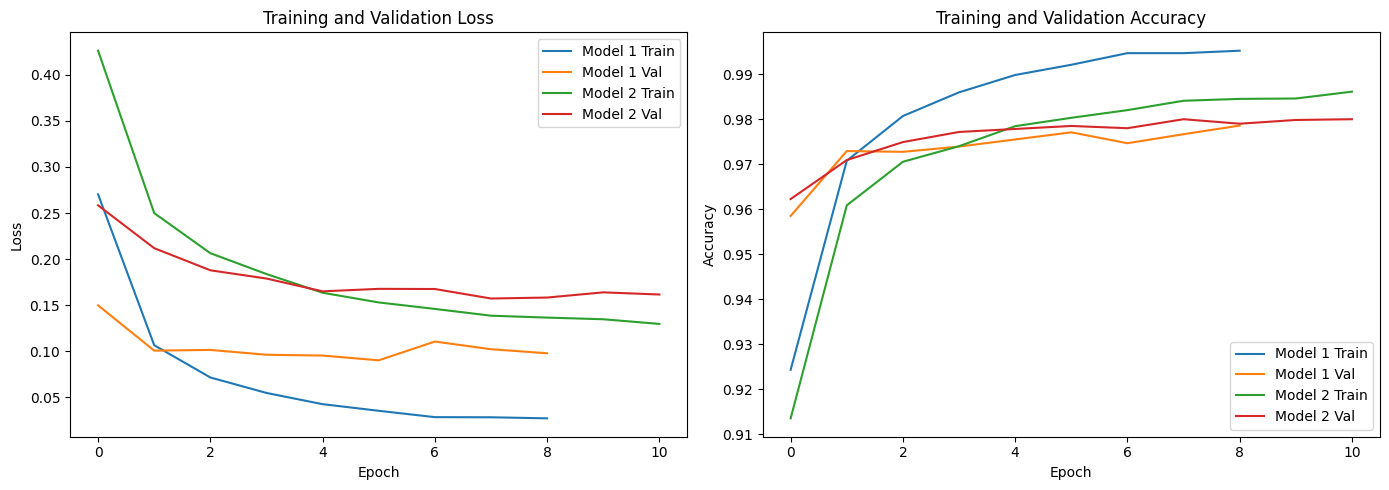

In [6]:
def plot_history(histories, names):
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history["loss"], label=f"{name} Train")
        plt.plot(history.history["val_loss"], label=f"{name} Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history["accuracy"], label=f"{name} Train")
        plt.plot(history.history["val_accuracy"], label=f"{name} Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history([history_1, history_2], ["Model 1", "Model 2"])

In [7]:
test_loss_a, test_acc_a = model_1.evaluate(test_images, test_labels, verbose=0)
test_loss_b, test_acc_b = model_2.evaluate(test_images, test_labels, verbose=0)

print(f"Model 1 - Test Accuracy: {test_acc_a:.4f}, Test Loss: {test_loss_a:.4f}")
print(f"Model 2 - Test Accuracy: {test_acc_b:.4f}, Test Loss: {test_loss_b:.4f}")

Model 1 - Test Accuracy: 0.9790, Test Loss: 0.0829
Model 2 - Test Accuracy: 0.9811, Test Loss: 0.1520


## Performance Analysis

| Metric                    | **Model 1**       | **Model 2**                   |
| ------------------------- | ----------------- | ----------------------------- |
| **Regularization** | L2 | Gaussian Noise, L1/L2, Batch Normalization, Dropout |
| **Final Training Loss**   | Very low (\~0.02) | Slightly higher (\~0.15)      |
| **Final Validation Loss** | Increasing (\~0.13)      | Higher but stable (\~0.17) |
| **Test Accuracy**         | **97.90%**        | **98.11%**                    |                                                    
| **Test Loss**             | **8.29%**        | **15.20%**                    |


### Model 1:
- Uses only L2 regularization.
- Very low training loss indicates that the model fits the training data well.
- Model performs well with 97.90% test accuracy.
- But the increasing validation loss towards the end are signs of overfitting.
- This is clear by the fact that the model has achieved high accuracy on the training set (shown by the graph) but did not perform the same on the test set.

### Model 2:
- Uses stronger regularization (Gaussian Noise, L1/L2, Batch Normalization, Dropout).
- Slightly higher training and validation losses, but more stable.
- Despite worse loss metrics, it achieved better test accuracy (98.11%).
- This implies better generalization.